# Classification by standard ML approach
In the following, we will run some experiments using some of the standard ML approaches, such as Random Forest, MLP, SVMs. These naïve methods will exploit the list of ingredients, rather than the structure of the entire recipe itself. This reasoning comes up naturally when considering such standards ML practices, since they do not keep in consideration the semantic structure of the sentences and do not share any weight in the network

### Imports

In [1]:
from tqdm.auto import tqdm
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import BernoulliRBM, MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

/Users/nicolapitzalis/anaconda3/envs/hlt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data loading

In [3]:
PATH_DATA = '/Users/nicolapitzalis/Documents/uni-ai/HLT/HLT-Project/dataset/ingredients_list_stanza_10k.csv'
PATH_VOCABULARY = '/Users/nicolapitzalis/Documents/uni-ai/HLT/HLT-Project/dataset/vocabulary_stanza_10k.csv'
PATH_RECIPES = '/Users/nicolapitzalis/Documents/uni-ai/HLT/HLT-Project/dataset/dataset_balanced_10k.csv'

data = pd.read_csv(PATH_DATA, low_memory=False)
vocabulary = pd.read_csv(PATH_VOCABULARY)

In [5]:
recipes = pd.read_csv(PATH_RECIPES)
labels = recipes['Vegetarian']

### Preprocessing
We need to create the one_hot_encoded version of the ingredients, both for the ingredient's vocabulary and for the matrix of recipes.

In [6]:
vocabulary = vocabulary.fillna('Missing')
ohe_vocabulary = pd.get_dummies(vocabulary, prefix='category').astype(int)

In [7]:
ohe_matrix = []

# Loop over each recipe in the data
for index, recipe in data.iterrows():
    ohe_recipe = np.zeros(len(ohe_vocabulary.columns))
    
    for ingredient in recipe:
        if pd.isnull(ingredient):
            continue
        
        # Check if the ingredient is in the one-hot vocabulary
        if f'category_{ingredient}' in ohe_vocabulary.columns:
            # Find the index for the ingredient
            ingredient_index = ohe_vocabulary.columns.get_loc(f'category_{ingredient}')
            
            # Set the corresponding position in ohe_recipe to 1
            ohe_recipe[ingredient_index] = 1

    ohe_matrix.append(ohe_recipe)

ohe_matrix = np.array(ohe_matrix)

In [11]:
labels = labels.to_numpy()

## Classification

In [13]:
X_train, X_test, y_train, y_test = train_test_split(ohe_matrix, labels, test_size=0.3, random_state=42, stratify=labels)

In [14]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5000, 1: 5000}


In [15]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 3500, 1: 3500}


In [16]:
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{0: 1500, 1: 1500}


### Random Forest

In [17]:
random_forest = RandomForestClassifier(criterion='gini', n_estimators=100, random_state=42, max_depth=None, min_samples_split=5, min_samples_leaf=1, n_jobs=-1)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Accuracy: 0.8706666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1500
           1       0.86      0.89      0.87      1500

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000

Accuracy Score: 0.8706666666666667


Confusion Matrix:
[[1274  226]
 [ 162 1338]]


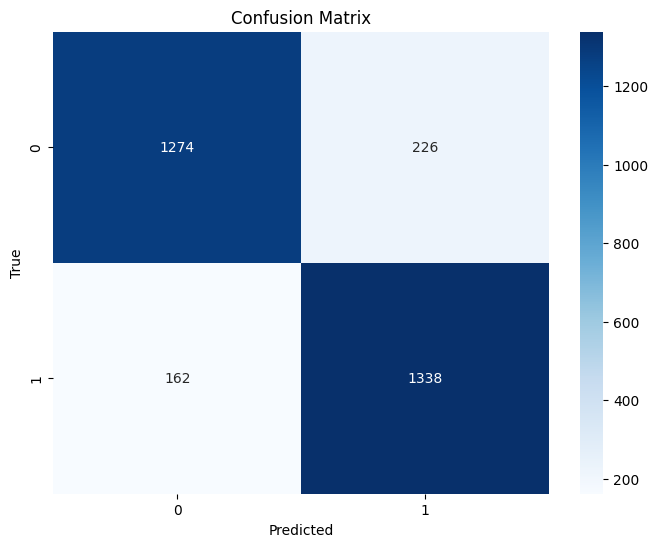

In [19]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]  
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [27]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Accuracy: 0.8726666666666667
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.88


Test Accuracy: 0.8726666666666667
Confusion Matrix:
[[1266  234]
 [ 148 1352]]


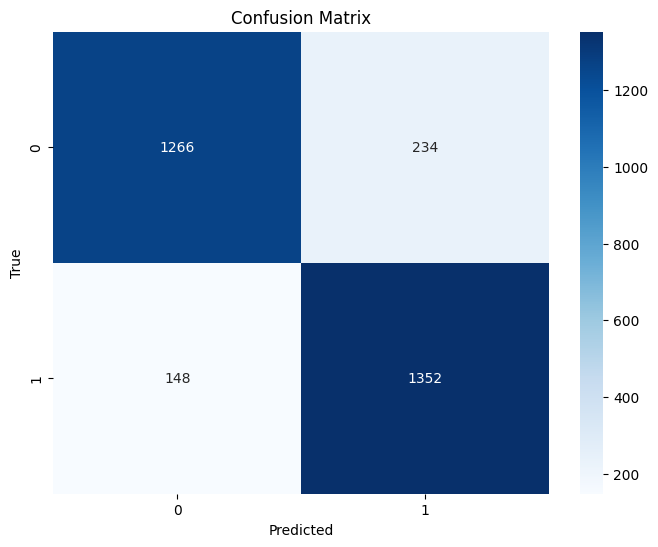

In [29]:
print("Test Accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### MLP

In [20]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=0.0001,
                    solver='adam', verbose=10, random_state=21, learning_rate_init=0.01)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Iteration 1, loss = 0.37016492
Iteration 2, loss = 0.12697363
Iteration 3, loss = 0.06797402
Iteration 4, loss = 0.04568066
Iteration 5, loss = 0.03622758
Iteration 6, loss = 0.02636126
Iteration 7, loss = 0.01939708
Iteration 8, loss = 0.01433541
Iteration 9, loss = 0.01070834
Iteration 10, loss = 0.00817415
Iteration 11, loss = 0.00681514
Iteration 12, loss = 0.00589878
Iteration 13, loss = 0.00541609
Iteration 14, loss = 0.00521912
Iteration 15, loss = 0.00490313
Iteration 16, loss = 0.00469806
Iteration 17, loss = 0.00460096
Iteration 18, loss = 0.00446057
Iteration 19, loss = 0.00422173
Iteration 20, loss = 0.00414082
Iteration 21, loss = 0.00409968
Iteration 22, loss = 0.00399767
Iteration 23, loss = 0.00398628
Iteration 24, loss = 0.00390211
Iteration 25, loss = 0.00385261
Iteration 26, loss = 0.00385868
Iteration 27, loss = 0.00394725
Iteration 28, loss = 0.00383929
Iteration 29, loss = 0.00383734
Iteration 30, loss = 0.00381639
Iteration 31, loss = 0.00365802
Iteration 32, los

Confusion Matrix:
[[1292  208]
 [  99 1401]]


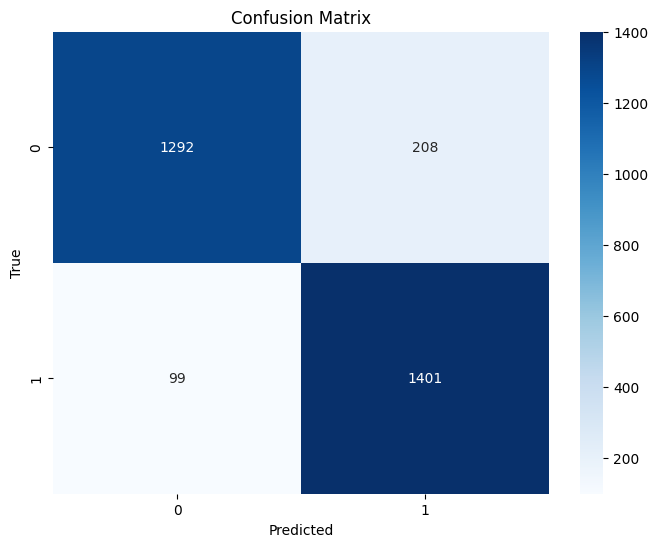

In [21]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [33]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

mlp = MLPClassifier(max_iter=300, random_state=21, verbose=10)
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, n_jobs=-1, verbose=10)
grid_search.fit(X_train, y_train)


print("Best parameters found: ", grid_search.best_params_)
y_pred = grid_search.best_estimator_.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 2/3; 2/36] START alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01
[CV 3/3; 2/36] START alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01
[CV 1/3; 2/36] START alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01
[CV 2/3; 1/36] START alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.001
[CV 1/3; 3/36] START alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.1
[CV 1/3; 1/36] START alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.001
[CV 3/3; 1/36] START alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.001
[CV 2/3; 3/36] START alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.1
[CV 3/3; 3/36] START alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.1
[CV 1/3; 4/36] START alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001
[CV 2/3; 4/36] START alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001

### SVM

In [23]:
svc = SVC(C=100, kernel='rbf', gamma=0.001)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.89      1500
           1       0.85      0.97      0.91      1500

    accuracy                           0.90      3000
   macro avg       0.91      0.90      0.90      3000
weighted avg       0.91      0.90      0.90      3000



Confusion Matrix:
[[1246  254]
 [  44 1456]]


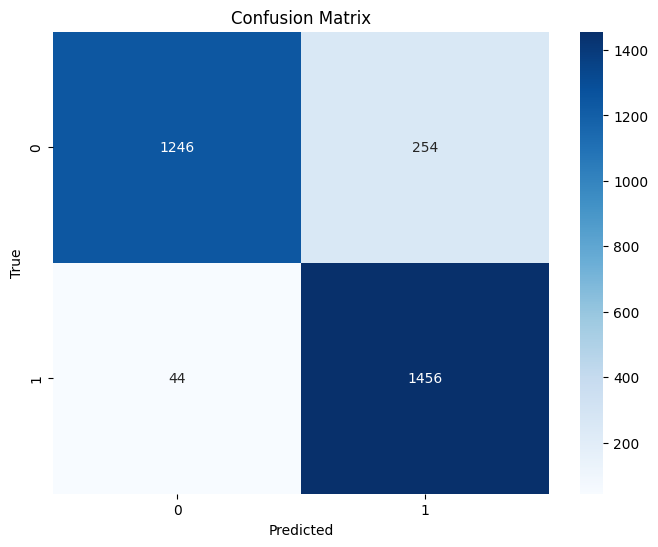

In [24]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [30]:
param_grid = [
    {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START C=1, gamma=0.001, kernel=rbf................................[CV 2/5; 3/8] START C=10, gamma=0.001, kernel=rbf...............................
[CV 4/5; 1/8] START C=1, gamma=0.001, kernel=rbf................................
[CV 1/5; 2/8] START C=1, gamma=0.0001, kernel=rbf...............................[CV 1/5; 3/8] START C=10, gamma=0.001, kernel=rbf...............................


[CV 5/5; 1/8] START C=1, gamma=0.001, kernel=rbf................................
[CV 3/5; 2/8] START C=1, gamma=0.0001, kernel=rbf...............................
[CV 4/5; 2/8] START C=1, gamma=0.0001, kernel=rbf...............................
[CV 2/5; 1/8] START C=1, gamma=0.001, kernel=rbf................................
[CV 2/5; 2/8] START C=1, gamma=0.0001, kernel=rbf...............................
[CV 5/5; 2/8] START C=1, gamma=0.0001, kernel=rbf...............................
[CV 3/5; 1/8] START C=1, gamma=0.001, kernel=rbf.

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             scoring='accuracy', verbose=10)

In [31]:
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.92


Test Accuracy: 0.9146666666666666
Confusion Matrix:
[[1299  201]
 [  55 1445]]


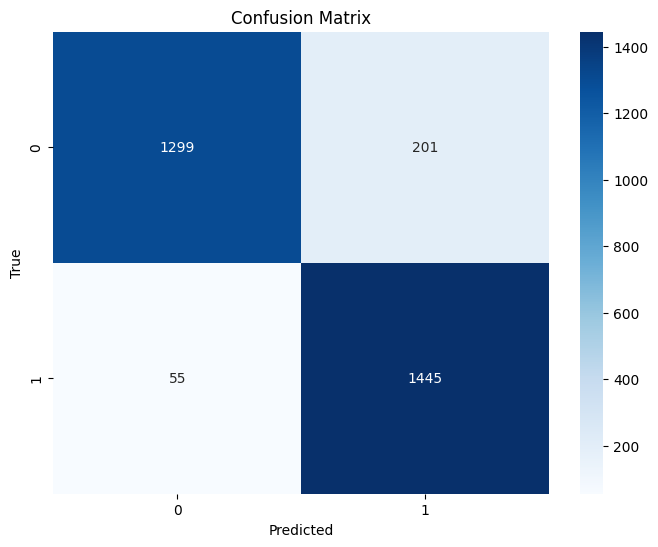

In [32]:
print("Test Accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()